Script to calculate the expected PV performance without weather

Import Packages

In [66]:
import numpy as np              
import matplotlib.pyplot as plt
import datetime
import ephem
import pandas as pd
import matplotlib.dates as mdates

Functions

In [67]:
def calculate_sun_position(latitude, longitude, date):
    # Calculate the sun's position for given coordinates and date
    observer = ephem.Observer()
    observer.lat = str(latitude)
    observer.lon = str(longitude)
    observer.date = date

    sun = ephem.Sun()
    sun.compute(observer)

    azimuth = np.rad2deg(sun.az)
    elevation = np.rad2deg(sun.alt)
    return azimuth, elevation


def calculate_delta_angle(sun_azimut, panel_orientation, sun_elevation, panel_tilt):
    # Calculate the angle between the sun and the solar panel
    # Convert to radians
    sun_azimut = np.deg2rad(sun_azimut)
    panel_orientation = np.deg2rad(panel_orientation)
    sun_elevation = np.deg2rad(sun_elevation)
    panel_tilt = np.deg2rad(panel_tilt)
    # Convert to spherical coordinates, r = 1
    theta_sun = np.pi / 2 - sun_elevation
    theta_panel = np.pi / 2 - panel_tilt
    phi_sun = sun_azimut
    phi_panel = panel_orientation
    # Calculate dot product of the two vectors
    dot_product = np.sin(theta_sun) * np.sin(theta_panel) * np.cos(
        phi_sun - phi_panel
    ) + np.cos(theta_sun) * np.cos(theta_panel)
    # Calculate angle in degrees
    angle = np.rad2deg(np.arccos(dot_product))
    return angle


def create_timestamps(date, time_step):
    # Create an array of timestamps for one day
    start_time = datetime.datetime(date.year, date.month, date.day)
    end_time = start_time + datetime.timedelta(days=1)
    num_steps = int((end_time - start_time) / time_step)
    timestamps = np.array([start_time + i * time_step for i in range(num_steps)])
    return timestamps


def get_sun_trajectory(latitude, longitude, timestamps, timezone):
    # Calculate the sun's position for each timestamp
    sun_azimuths = np.empty(len(timestamps))
    sun_elevations = np.empty(len(timestamps))
    for i, timestamp in enumerate(timestamps):
        timestamp = timestamp - datetime.timedelta(hours=timezone)
        azimuth, elevation = calculate_sun_position(latitude, longitude, timestamp)
        sun_azimuths[i] = azimuth
        sun_elevations[i] = elevation
    return sun_azimuths, sun_elevations


def get_pv_sun_angle(azimuths, elevations, panel_orientation, panel_tilt):
    # Calculate the angle between the sun and the solar panel for each timestep
    angles = np.empty((len(panel_orientation), len(azimuths)))
    for num_panel in range(len(panel_orientation)):
        for i in range(len(azimuths)):
            angles[num_panel, i] = calculate_delta_angle(
                azimuths[i],
                panel_orientation[num_panel],
                elevations[i],
                panel_tilt[num_panel],
            )
    return angles


def calc_irradiance_scaling(elevations):
    # Calculate the irradiance scaling for each elevation
    irradiance = np.zeros(len(elevations))
    for i in range(len(elevations)):
        if elevations[i] > 0:
            irradiance[i] = np.sin(np.deg2rad(elevations[i]))
    return irradiance


def calc_power_ratio(angles, peak_power):
    # Calculate the power ratio for each angle with respect to the peak power
    power_ratio = np.zeros([len(angles), len(angles[0])])
    for panel in range(len(angles)):
        for i in range(len(power_ratio[0])):
            if angles[panel][i] < 90:
                power_ratio[panel][i] += (np.cos(np.deg2rad(angles[panel][i])) 
                                   * peak_power[panel])
    return power_ratio


def create_datainfo_dict_and_dataframe(
    latitude,
    longitude,
    timezone,
    date,
    time_step,
    limit_data,
    timestamps,
    sun_azimuths,
    sun_elevations,
    terrain_mask,
    terrain_factor,
    irradiance_scaling,
    power_ratio,
    orientation,
    tilt,
    peak_power,
    angles,
):
    # Create a dict with info and adataframe with the simulation results
    data_info = {
        "latitude": latitude,
        "longitude": longitude,
        "timezone": timezone,
        "date": date.strftime("%d.%m.%Y"),
        "time_step": time_step,
        "limit_data": limit_data,
    }
    df_data = pd.DataFrame(
        {
            "timestamps": timestamps,
            "sun_azimuths": sun_azimuths,
            "sun_elevations": sun_elevations,
            "terrain_mask": terrain_mask,
            "terrain_factor": terrain_factor,
            "irradiance_scaling": irradiance_scaling,
        }
    )
    for i in range(len(orientation)):
        df_data[f"sun_panel_angle_{i+1}"] = angles[i]
        df_data[f"power_ratio_{i+1}"] = power_ratio[i]
        data_info[f"num_panels"] = len(orientation)
        data_info[f"orientation_{i+1}"] = orientation[i]
        data_info[f"tilt_{i+1}"] = tilt[i]
        data_info[f"peak_power_{i+1}"] = peak_power[i]
    df_data["total_power_ratio"] = df_data.filter(like="power_ratio").sum(axis=1)
    return data_info, df_data


def handle_summertime(date, timezone):
    # Check if the date is in summertime and adjust the timezone
    # Calculate the last Sunday of March at 02:00
    changedate_1 = datetime.datetime(date.year, 3, 31, 2)
    while changedate_1.weekday() != 6:  # Sunday is represented by 6
        changedate_1 -= datetime.timedelta(days=1)

    # Calculate the last Sunday of October at 03:00
    changedate_2 = datetime.datetime(date.year, 10, 31, 3)
    while changedate_2.weekday() != 6:  # Sunday is represented by 6
        changedate_2 -= datetime.timedelta(days=1)
    # Apply the timezone change
    if changedate_1 <= date <= changedate_2:
        timezone += 1
    return timezone


def calculate_terrain_mask(terrain_file, sun_azimuths):
    # Calculate the terrain mask for each timestep
    terrain_mask = np.zeros(len(sun_azimuths))
    terrain_data = np.genfromtxt(terrain_file, delimiter=',')
    terrain_azimuths = terrain_data[:, 0]
    terrain_elevation = terrain_data[:, 1]
    azimuths_indices = np.empty(len(terrain_azimuths), dtype=np.int32)
    for i, azimuth in enumerate(terrain_azimuths):
        closest_index = np.argmin(np.abs(sun_azimuths - azimuth))
        azimuths_indices[i] = closest_index
        terrain_mask[closest_index] = terrain_elevation[i]
    for i in range(len(terrain_azimuths)):
        startindex = azimuths_indices[i]
        stopindex = azimuths_indices[(i+1)%len(terrain_azimuths)]
        if startindex < stopindex:
            # Interpolate values between startindex and stopindex
            terrain_mask[startindex:stopindex+1] = np.interp(
                np.arange(startindex, stopindex+1),
                [startindex, stopindex],
                [terrain_mask[startindex], terrain_mask[stopindex]]
            )
        else:
            # Get interpolation value for the start and end of the array
            len_mask = len(terrain_mask)
            span = len_mask - startindex + stopindex
            valuespan = terrain_elevation[0] - terrain_elevation[-1]
            step = valuespan / span
            value_end = terrain_elevation[-1] + step * (len_mask - startindex)
            value_begin = value_end + step
            # Interpolate values from startindex to the end of the array
            terrain_mask[startindex:] = np.interp(
                np.arange(startindex, len_mask),
                [startindex, len_mask-1],
                [terrain_elevation[-1], value_end]
            )
            # Interpolate values from the beginning of the array to stopindex
            terrain_mask[:stopindex+1] = np.interp(
                np.arange(stopindex+1),
                [0, stopindex],
                [value_begin, terrain_elevation[0]]
            )        
    return terrain_mask


def calculate_terrain_factor(terrain_mask, sun_elevations):
    # Calculate the terrain factor for each timestep
    terrain_factor = np.ones(len(sun_elevations))
    for i in range(len(sun_elevations)):
        if terrain_mask[i] > sun_elevations[i] or sun_elevations[i] < 0:
            terrain_factor[i] = 0
    return terrain_factor


def calc_expected_power(time_step, power_ratio, irradiance_scaling, terrain_factor):
    # Calculate the expected power output
    seconds_per_step = time_step.total_seconds()
    energy_raw = np.trapz(power_ratio * irradiance_scaling * terrain_factor)
    energy = np.round(
        energy_raw * seconds_per_step / 3600 / 1000, 1
    ) # in kWh
    return energy


def calc_expected_power_year(
        date, 
        latitude, 
        longitude, 
        timezone, 
        terrain_file, 
        auto_summertime, 
        orientation, tilt, 
        peak_power
    ): 
    # Calculate the expected power output for all days of a year
    year = date.year
    if terrain_file is not None:
        time_step = datetime.timedelta(seconds=1)
    else:
        time_step = datetime.timedelta(minutes=1)
    num_days = 366 if (year % 4 == 0 and year % 100 != 0) or year % 400 == 0 else 365
    date_array = [np.array([datetime.datetime(year, 1, 1) 
                            + datetime.timedelta(days=i) 
                            for i in range(num_days)])]
    power_array = np.zeros([len(tilt)+1, num_days])
    for i, date in enumerate(date_array[0]):
        if i%7 == 0:
            print(f"Calculating for week {i//7+1} of {num_days//7}")
        timestamps = create_timestamps(date, time_step)
        if auto_summertime:
            timezone = handle_summertime(date, timezone)
        sun_azimuths, sun_elevations = get_sun_trajectory(
                                            latitude, 
                                            longitude, 
                                            timestamps, 
                                            timezone
                                        )
        angles = get_pv_sun_angle(sun_azimuths, sun_elevations, orientation, tilt)
        if terrain_file is not None:
            terrain_mask = calculate_terrain_mask(terrain_file, sun_azimuths)
            terrain_factor = calculate_terrain_factor(terrain_mask, sun_elevations)
        else:
            terrain_factor = np.ones(len(sun_azimuths))
        irradiance_scaling = calc_irradiance_scaling(sun_elevations)
        power_ratio = calc_power_ratio(angles, peak_power)
        for panel in range(len(tilt)):
            power_array[panel, i] = calc_expected_power(
                                        time_step, 
                                        power_ratio[panel], 
                                        irradiance_scaling, 
                                        terrain_factor
                                    )
        power_array[-1, i] = np.sum(power_array[:-1, i])
    return date_array, power_array
    

def limit_to_daylight(df_data):
    # Limit the data to daylight hours
    df_data = df_data[df_data["sun_elevations"] >= 0]
    return df_data


def generate_data(
    date,
    time_step,
    latitude,
    longitude,
    terrain_data,
    timezone,
    auto_summertime,
    orientation,
    tilt,
    peak_power,
    limit_data,
):
    timestamps = create_timestamps(date, time_step)
    if auto_summertime:
        timezone = handle_summertime(date, timezone)
    sun_azimuths, sun_elevations = get_sun_trajectory(
        latitude, longitude, timestamps, timezone
    )
    angles = get_pv_sun_angle(sun_azimuths, sun_elevations, orientation, tilt)
    if terrain_data is not None:
        terrain_mask = calculate_terrain_mask(terrain_data, sun_azimuths)
        terrain_factor = calculate_terrain_factor(terrain_mask, sun_elevations)
    else:
        terrain_mask = np.zeros(len(sun_azimuths))
        terrain_factor = np.ones(len(sun_azimuths))
    irradiance_scaling = calc_irradiance_scaling(sun_elevations)
    power_ratio = calc_power_ratio(angles, peak_power)
    data_info, df_data = create_datainfo_dict_and_dataframe(
        latitude,
        longitude,
        timezone,
        date,
        time_step,
        limit_data,
        timestamps,
        sun_azimuths,
        sun_elevations,
        terrain_mask,
        terrain_factor,
        irradiance_scaling,
        power_ratio,
        orientation,
        tilt,
        peak_power,
        angles,
    )
    if limit_data:
        df_data = limit_to_daylight(df_data)
    return data_info, df_data


Plot Functions

In [68]:
def plot_sun_trajectory(data_info, df_data, closest_indices, cardinal_directions):
    # Plot the sun's trajectory
    fig, ax = plt.subplots()
    ax.scatter(
        df_data["timestamps"],
        df_data["sun_elevations"],
        color="orange",
        label="Sun trajectory",
    )
    ax.scatter(df_data["timestamps"], 
            df_data["terrain_mask"], 
            color="black", 
            label="Terrain mask",
    )
    ax.legend()
    ax.set_xlabel("Daytime")
    ax.set_ylabel("Elevation in degrees")
    titletext = (
        "Data for Lat: "
        + str(data_info["latitude"])
        + " and Lon: "
        + str(data_info["longitude"])
        + " on "
        + str(data_info["date"])
        + "\n"
        + "Sun trajectory and terrain mask"
    )
    ax.set_title(titletext)
    ax.grid(True)
    # Format xticklabels to use "%H"
    myFmt = mdates.DateFormatter("%H")
    plt.gca().xaxis.set_major_formatter(myFmt)
    # Add second x-axis with cardinal directions
    ax2 = ax.twiny()
    ax2.set_xlim(-(0.05 * len(df_data)),len(df_data) + (0.05 * len(df_data)))
    ax2.set_xticks(closest_indices)
    ax2.set_xticklabels(cardinal_directions)
    plt.show()


def plot_panel_angles(data_info, df_data, closest_indices, cardinal_directions):
    # Plot the angle between the sun and the solar panel
    fig, ax = plt.subplots()
    for i in range(data_info["num_panels"]):
        ax.scatter(
            df_data["timestamps"],
            df_data[f"sun_panel_angle_{i+1}"],
            label=f"Panel {i+1}",
        )
    ax.set_xlabel("Daytime")
    ax.set_ylabel("Angle in degrees")
    titletext = (
        "Data for Lat: "
        + str(data_info["latitude"])
        + " and Lon: "
        + str(data_info["longitude"])
        + " on "
        + str(data_info["date"])
        + "\n"
        + "Angle between sun and solar panel"
    )
    ax.set_title(titletext)
    ax.grid(True)
    ax.legend()
    # Format xticklabels to use "%H"
    myFmt = mdates.DateFormatter("%H")
    plt.gca().xaxis.set_major_formatter(myFmt)
    # Add second x-axis with cardinal directions
    ax2 = ax.twiny()
    ax2.set_xlim(-(0.05 * len(df_data)),len(df_data) + (0.05 * len(df_data)))
    ax2.set_xticks(closest_indices)
    ax2.set_xticklabels(cardinal_directions)
    plt.show()


def plot_normalized_power(data_info, df_data, closest_indices, cardinal_directions):
    # Plot the self-normalized power output
    fig, ax = plt.subplots()
    for i in range(data_info["num_panels"]):
        ax.scatter(
            df_data["timestamps"],
            (df_data[f"power_ratio_{i+1}"] 
             * df_data["irradiance_scaling"] 
             * df_data["terrain_factor"] 
             / data_info[f"peak_power_{i+1}"]
            ),
            label=f"Panel {i+1}",
        )
    ax.set_xlabel("Daytime")
    ax.set_ylabel("Self-normalized power")
    titletext = (
        "Data for Lat: "
        + str(data_info["latitude"])
        + " and Lon: "
        + str(data_info["longitude"])
        + " on "
        + str(data_info["date"])
        + "\n"
        + "Normalized power output"
    )
    ax.set_title(titletext)
    ax.grid(True)
    ax.legend()
    # Format xticklabels to use "%H"
    myFmt = mdates.DateFormatter("%H")
    plt.gca().xaxis.set_major_formatter(myFmt)
    # Add second x-axis with cardinal directions
    ax2 = ax.twiny()
    ax2.set_xlim(-(0.05 * len(df_data)),len(df_data) + (0.05 * len(df_data)))
    ax2.set_xticks(closest_indices)
    ax2.set_xticklabels(cardinal_directions)
    plt.show()

def plot_expected_power(data_info, df_data, closest_indices, cardinal_directions):
    # Calculate the total expected power output
    total_energy = calc_expected_power(data_info["time_step"], 
                                       df_data["total_power_ratio"], 
                                       df_data["irradiance_scaling"], 
                                       df_data["terrain_factor"]
    )
    # Plot the expected power output
    fig, ax = plt.subplots()
    for panel in range(data_info["num_panels"]):
        # Calculate the expected power output for each panel
        panel_energy = calc_expected_power(data_info["time_step"], 
                                           df_data[f"power_ratio_{panel + 1}"], 
                                           df_data["irradiance_scaling"], 
                                           df_data["terrain_factor"]
        )
        ax.scatter(
            df_data["timestamps"],
            df_data["power_ratio_" + str(panel + 1)] 
            * df_data["irradiance_scaling"] 
            * df_data["terrain_factor"],
            label="Panel " + str(panel + 1) + ": " + str(panel_energy) + " kWh",
        )
    ax.scatter(
        df_data["timestamps"],
        df_data["total_power_ratio"] * df_data["irradiance_scaling"] * df_data["terrain_factor"],
        color="r",
        label="Total: " + str(total_energy) + " kWh",
    )
    ax.set_xlabel("Daytime")
    ax.set_ylabel("Power in Watts")
    ax.legend()
    titletext = (
        "Data for Lat: "
        + str(data_info["latitude"])
        + " and Lon: "
        + str(data_info["longitude"])
        + " on "
        + str(data_info["date"])
        + "\n"
        + "Expected power output"
    )
    ax.set_title(titletext)
    ax.grid(True)
    # Format xticklabels to use "%H"
    myFmt = mdates.DateFormatter("%H")
    plt.gca().xaxis.set_major_formatter(myFmt)
    # Add second x-axis with cardinal directions
    ax2 = ax.twiny()
    ax2.set_xlim(-(0.05 * len(df_data)),len(df_data) + (0.05 * len(df_data)))
    ax2.set_xticks(closest_indices)
    ax2.set_xticklabels(cardinal_directions)
    plt.show()


def plot_yearly_power(date_array, power_array, selfnormalize, peak_power):
    # Plot the expected power output for all days of a year
    fig, ax = plt.subplots()
    if selfnormalize:
        for i in range(len(power_array) - 1):
            power_array[i] = power_array[i] / peak_power[i] * 1000 # good scaling factor?
        ylabel_text = "Self-normalized power"
        titletext = "Self-normalized expected power output over the year"
    else:
        ax.scatter(date_array[0], power_array[-1], label="Total: " + str(int(np.sum(power_array[-1]))) + " kWh")
        ylabel_text = "Power in kWh"
        titletext = "Expected power output over the year"
    for i in range(len(power_array) - 1):
        if selfnormalize:
            labeltext = "Panel " + str(i + 1) + ": " + str(int(np.sum(power_array[i])))
        else:
            labeltext = "Panel " + str(i + 1) + ": " + str(int(np.sum(power_array[i]))) + " kWh"
        ax.scatter(date_array[0], power_array[i], label=labeltext)
    ax.set_xlabel("Date")
    ax.set_ylabel(ylabel_text)
    ax.legend()
    ax.set_title(titletext)
    ax.grid(True)
    plt.show()

def plot_select(data_info, df_data, sun, angles, norm_power, power, popout=False):
    if data_info["limit_data"]:
        target_azimuths = []
        cardinal_directions_lookup = ["N", "NE", "E", "SE", "S", "SW", "W", "NW"]
        cardinal_directions = []
        azimuth_min = df_data["sun_azimuths"].iloc[0] 
        azimuth_max = df_data["sun_azimuths"].iloc[-1]
        for i, angle in enumerate(range(0, 360, 45)):
            if azimuth_min <= angle <= azimuth_max:
                target_azimuths.append(angle)
                cardinal_directions.append(cardinal_directions_lookup[i])
    else:
        target_azimuths = [0, 45, 90, 135, 180, 225, 270, 315]
        cardinal_directions = ["N", "NE", "E", "SE", "S", "SW", "W", "NW"]
    closest_indices = []
    for target in target_azimuths:
        closest_indices.append(np.abs(df_data["sun_azimuths"] - target).argmin())    
    if popout:
        %matplotlib qt
    else:
        %matplotlib inline
    if sun:
        plot_sun_trajectory(data_info, df_data, closest_indices, cardinal_directions)
    if angles:
        plot_panel_angles(data_info, df_data, closest_indices, cardinal_directions)
    if norm_power:
        plot_normalized_power(data_info, df_data, closest_indices, cardinal_directions)
    if power:
        plot_expected_power(data_info, df_data, closest_indices, cardinal_directions)

User input

In [69]:
# Coordinates in degrees
latitude = 48.8 # 48.8
longitude = 9
timezone = 1 # Germany: UTC +1 
auto_summertime = True # Automatically handle summertime for Germany (or similar)

# Panel orientation, tilt and peak power
orientation = np.array([96, 276]) # degrees, north = 0, east = 90, ...
tilt = np.array([30, 44]) # degrees, 0 = horizontal, 90 = vertical
peak_power = np.array([3320, 4980]) # Watts peak

# Terrain elevation data, use None for no data, otherwise provide a path to a .csv file
# terrain_data = "terrain_example_1.csv" # Use "None" if no data is available
terrain_data = None

# Date and stepsize
# Either use specific date or current date + offset, comment unused lines out
# date = (datetime.datetime.now() # Current date
#         + datetime.timedelta(weeks=0, days=0)) # Add/ substract weeks and days
date = datetime.datetime.strptime("05.02.2024", "%d.%m.%Y") # Specific date
time_step = datetime.timedelta(minutes=1, seconds=0) # Time steps for simulation

# Limit data to daylight hours
limit_data = True

# Select plots to show and popout option
sun, angles, normpower, power, popout = True, True, True, True, False
yearly, selfnormalize = True, True

Run script

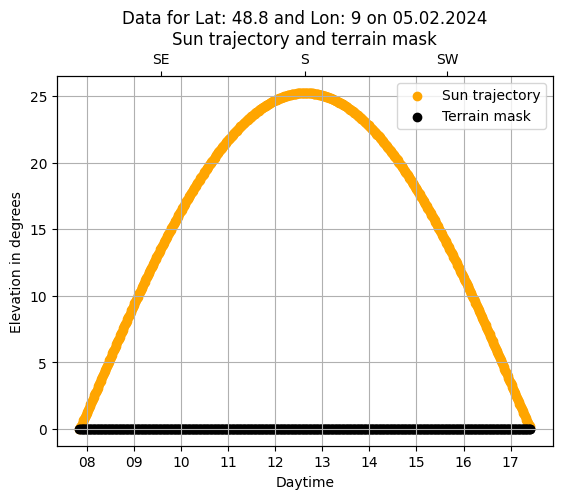

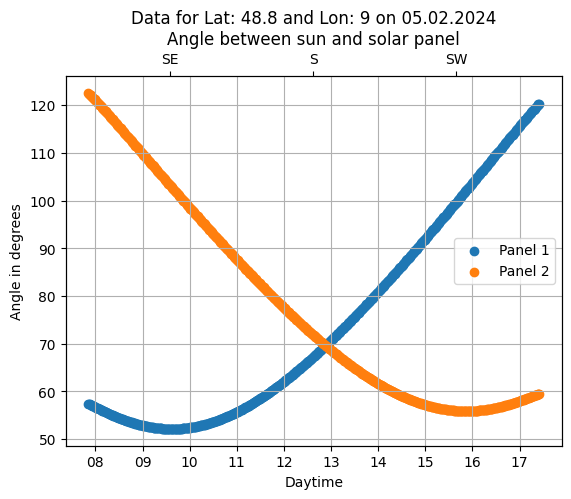

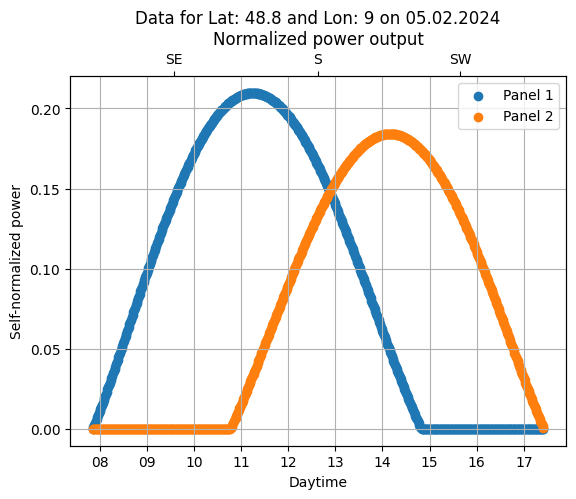

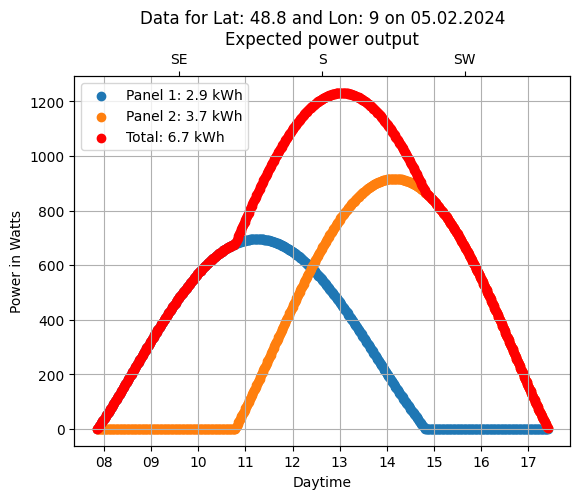

Calculating for week 1 of 52
Calculating for week 2 of 52
Calculating for week 3 of 52
Calculating for week 4 of 52
Calculating for week 5 of 52
Calculating for week 6 of 52
Calculating for week 7 of 52
Calculating for week 8 of 52
Calculating for week 9 of 52
Calculating for week 10 of 52
Calculating for week 11 of 52
Calculating for week 12 of 52
Calculating for week 13 of 52
Calculating for week 14 of 52
Calculating for week 15 of 52
Calculating for week 16 of 52
Calculating for week 17 of 52
Calculating for week 18 of 52
Calculating for week 19 of 52
Calculating for week 20 of 52
Calculating for week 21 of 52
Calculating for week 22 of 52
Calculating for week 23 of 52
Calculating for week 24 of 52
Calculating for week 25 of 52
Calculating for week 26 of 52
Calculating for week 27 of 52
Calculating for week 28 of 52
Calculating for week 29 of 52
Calculating for week 30 of 52
Calculating for week 31 of 52
Calculating for week 32 of 52
Calculating for week 33 of 52
Calculating for wee

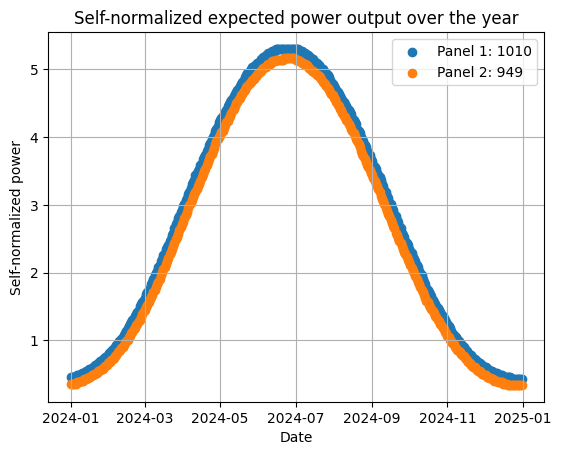

In [70]:
data_info, df_data = generate_data(
    date,
    time_step,
    latitude,
    longitude,
    terrain_data,
    timezone,
    auto_summertime,
    orientation,
    tilt,
    peak_power,
    limit_data,
)

# Plot the results
plot_select(data_info, df_data, sun, angles, normpower, power, popout)
if yearly:
    date_array, power_array = calc_expected_power_year(
        date,
        latitude,
        longitude,
        timezone,
        terrain_data,
        auto_summertime,
        orientation,
        tilt,
        peak_power,
    )
    plot_yearly_power(date_array, power_array, selfnormalize, peak_power)

Testing Area